fps :  20.0
(720, 1280, 3)


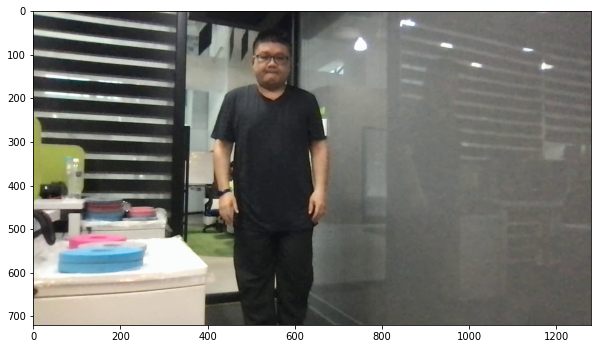

In [9]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

video_path = Path('record/record_data.mp4')
# count_stop = 620
count_stop = 300

cap = cv2.VideoCapture( str(video_path) )

fps = cap.get(cv2.CAP_PROP_FPS)
print('fps : ', fps)

count = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    count += 1
    if count == count_stop:
        print(frame.shape)
        break
    

cap.release()

image_bgr = frame



plt.figure(figsize=(10,10))
plt.imshow(image_bgr[:,:,::-1])
plt.show()







<tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.16905382, 0.6267971 , 0.56421053],
         [0.14877653, 0.6521407 , 0.840127  ],
         [0.15128794, 0.60121536, 0.8686405 ],
         [0.1714592 , 0.6860178 , 0.55675995],
         [0.17548615, 0.56988966, 0.6955191 ],
         [0.2695467 , 0.74887615, 0.6970849 ],
         [0.2796574 , 0.5116757 , 0.8740872 ],
         [0.43651345, 0.7903554 , 0.86428815],
         [0.43263972, 0.47741896, 0.847585  ],
         [0.57395697, 0.78101003, 0.86754626],
         [0.56986016, 0.47353053, 0.8696678 ],
         [0.618534  , 0.6883102 , 0.8883294 ],
         [0.6169483 , 0.54798084, 0.8615191 ],
         [0.85177803, 0.68306744, 0.62073714],
         [0.84679073, 0.5440072 , 0.7694721 ],
         [0.98995847, 0.669579  , 0.70372045],
         [0.98901033, 0.55914724, 0.6382103 ]]]], dtype=float32)>

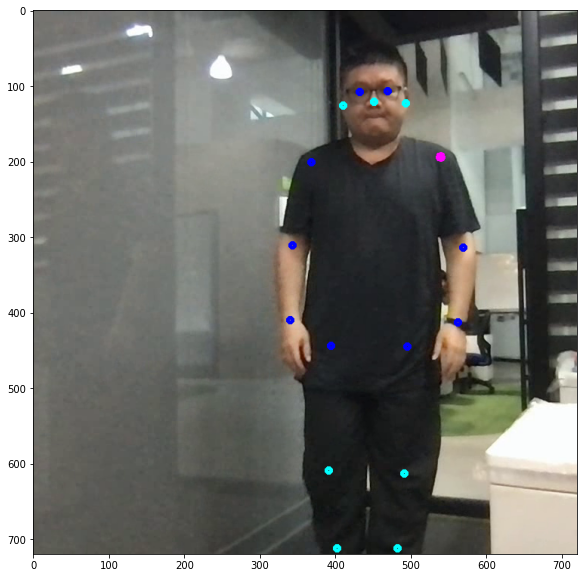

In [10]:
import tensorflow as tf

model_path = 'utils/models/movenet_t'

model_load = tf.saved_model.load(model_path)
model = model_load.signatures['serving_default']
_, target_height, target_width, _ = model.inputs[0].shape


frame = cv2.flip(frame, 1)
    
high, width, _ = frame.shape
# square
if high < width:
    x = int((width-high)/2); y = 0
    w = high; h = high; width = high
    frame = frame[y:y+h, x:x+w]
elif high > width:
    x = 0; y = int((high-width)/2)
    w = width; h = width; high = width
    frame = frame[y:y+h, x:x+w]

image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image_resize = cv2.resize(image_rgb, (target_width, target_height), interpolation=cv2.INTER_AREA)
image_r0 = tf.expand_dims(image_resize, axis=0)


input_image = tf.cast(image_r0, dtype=tf.int32)
keypoints_with_scores = model(input_image)['output_0']

# user_keypoints_with_scores = keypoints_with_scores
real_keypoints_with_scores = keypoints_with_scores
display(real_keypoints_with_scores)

count = 0
for keypoint in keypoints_with_scores[0][0]:
    y_coordinate = int( keypoint[0] * high  )
    x_coordinate = int( keypoint[1] * width )
    score = keypoint[2]

    if score > 0.8:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (0,0,255), 3)
    elif score > 0.4:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (0,255,255), 3)
    else:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (255,0,0), 3)

    if count == 5:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (255,0,255), 5)
        
    count += 1




plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.show()



In [41]:
real_keypoints_with_scores

<tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[ 0.00276968,  0.2886609 ,  0.03066781],
         [ 0.5782075 ,  0.7413625 ,  0.15587515],
         [ 0.5779402 ,  0.7323239 ,  0.07973945],
         [-0.0097529 ,  0.42127427,  0.05337331],
         [ 0.5823061 ,  0.72416884,  0.11080667],
         [ 0.07066832,  0.52815646,  0.53881407],
         [ 0.18262844,  0.06750787,  0.712834  ],
         [ 0.03684491,  0.74678874,  0.19893965],
         [ 0.55187213,  0.03247092,  0.48720133],
         [ 0.01459985,  0.77232456,  0.07711804],
         [ 0.8660691 , -0.00174816,  0.3631592 ],
         [ 0.8872545 ,  0.5690039 ,  0.39800325],
         [ 0.928414  ,  0.2338845 ,  0.5972313 ],
         [ 0.97572535,  0.6423678 ,  0.04493067],
         [ 0.99362206,  0.00154243,  0.05547276],
         [ 0.7790904 ,  0.77830607,  0.13910905],
         [ 0.78303254,  0.7660943 ,  0.0847604 ]]]], dtype=float32)>

In [34]:
import numpy as np

def changeAngleLength(pt1, pt2):
    y1 = pt1[0]; x1 = pt1[1]
    y2 = pt2[0]; x2 = pt2[1]
    x_diff =     x2 - x1
    y_diff = - ( y2 - y1 )

    vector = np.complex(x_diff, y_diff)
    # _angle = np.angle(vector, deg=True)
    _angle  = float( np.angle(vector) )
    _length = float( (x_diff ** 2 + y_diff ** 2) ** (0.5) )
    return _angle, _length

def changeVector(pt1, pt2):
    y1 = pt1[0]; x1 = pt1[1]
    y2 = pt2[0]; x2 = pt2[1]
    x_diff = float(     x2 - x1   )
    y_diff = float( - ( y2 - y1 ) )
    return y_diff, x_diff
    
def next_coordinate_from_angle(y, x, _angle, _length):
    x_new = x + np.cos(_angle) * _length
    y_new = y - np.sin(_angle) * _length
    return y_new, x_new

def next_coordinate_from_vector(y, x, y_diff, x_diff):
    x_new = x + x_diff
    y_new = y - y_diff
    return y_new, x_new

# 對於肩膀 髖骨 互算
# 5, 6, 11, 12
def angleLengthTwice(keypoints, twice_list):
    twice_dictionary = {
        'al_13':{},
        'al_24':{},
        'al_31':{},
        'al_42':{},
    }
    index_1, index_2, index_3, index_4 = twice_list

    _keys = changeAngleLength(keypoints[index_1], keypoints[index_3])
    twice_dictionary['al_13']['angle']  = _keys[0]
    twice_dictionary['al_13']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_2], keypoints[index_4])
    twice_dictionary['al_24']['angle']  = _keys[0]
    twice_dictionary['al_24']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_3], keypoints[index_1])
    twice_dictionary['al_31']['angle']  = _keys[0]
    twice_dictionary['al_31']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_4], keypoints[index_2])
    twice_dictionary['al_42']['angle']  = _keys[0]
    twice_dictionary['al_42']['length'] = _keys[1]

    return twice_dictionary


def vectorTwice(keypoints, twice_list):
    twice_dictionary = {
        'al_13':{},
        'al_24':{},
        'al_31':{},
        'al_42':{},
    }
    index_1, index_2, index_3, index_4 = twice_list

    _keys = changeVector(keypoints[index_1], keypoints[index_3])
    twice_dictionary['al_13']['y_diff'] = _keys[0]
    twice_dictionary['al_13']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_2], keypoints[index_4])
    twice_dictionary['al_24']['y_diff'] = _keys[0]
    twice_dictionary['al_24']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_3], keypoints[index_1])
    twice_dictionary['al_31']['y_diff'] = _keys[0]
    twice_dictionary['al_31']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_4], keypoints[index_2])
    twice_dictionary['al_42']['y_diff'] = _keys[0]
    twice_dictionary['al_42']['x_diff'] = _keys[1]

    return twice_dictionary


def angleLengthVectorTwice(keypoints, twice_list):
    twice_dictionary = {
        'al_13':{},
        'al_24':{},
        'al_31':{},
        'al_42':{},
    }
    index_1, index_2, index_3, index_4 = twice_list

    _keys = changeAngleLength(keypoints[index_1], keypoints[index_3])
    twice_dictionary['al_13']['angle']  = _keys[0]
    twice_dictionary['al_13']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_2], keypoints[index_4])
    twice_dictionary['al_24']['angle']  = _keys[0]
    twice_dictionary['al_24']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_3], keypoints[index_1])
    twice_dictionary['al_31']['angle']  = _keys[0]
    twice_dictionary['al_31']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_4], keypoints[index_2])
    twice_dictionary['al_42']['angle']  = _keys[0]
    twice_dictionary['al_42']['length'] = _keys[1]

    _keys = changeVector(keypoints[index_1], keypoints[index_3])
    twice_dictionary['al_13']['y_diff'] = _keys[0]
    twice_dictionary['al_13']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_2], keypoints[index_4])
    twice_dictionary['al_24']['y_diff'] = _keys[0]
    twice_dictionary['al_24']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_3], keypoints[index_1])
    twice_dictionary['al_31']['y_diff'] = _keys[0]
    twice_dictionary['al_31']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_4], keypoints[index_2])
    twice_dictionary['al_42']['y_diff'] = _keys[0]
    twice_dictionary['al_42']['x_diff'] = _keys[1]

    return twice_dictionary




def angleLengthTriple(keypoints, triple_list):
    triple_dictionary = {
        'al_12':{},
        'al_23':{},
        'al_13':{},
    }
    index_1, index_2, index_3 = triple_list

    _keys = changeAngleLength(keypoints[index_1], keypoints[index_2])
    triple_dictionary['al_12']['angle']  = _keys[0]
    triple_dictionary['al_12']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_2], keypoints[index_3])
    triple_dictionary['al_23']['angle']  = _keys[0]
    triple_dictionary['al_23']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_1], keypoints[index_3])
    triple_dictionary['al_13']['angle']  = _keys[0]
    triple_dictionary['al_13']['length'] = _keys[1]

    return triple_dictionary

def vectorTriple(keypoints, triple_list):
    triple_dictionary = {
        'al_12':{},
        'al_23':{},
        'al_13':{},
    }
    index_1, index_2, index_3 = triple_list

    _keys = changeVector(keypoints[index_1], keypoints[index_2])
    triple_dictionary['al_12']['y_diff'] = _keys[0]
    triple_dictionary['al_12']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_2], keypoints[index_3])
    triple_dictionary['al_23']['y_diff'] = _keys[0]
    triple_dictionary['al_23']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_1], keypoints[index_3])
    triple_dictionary['al_13']['y_diff'] = _keys[0]
    triple_dictionary['al_13']['x_diff'] = _keys[1]

    return triple_dictionary

def angleLengthVectorTriple(keypoints, triple_list):
    triple_dictionary = {
        'al_12':{},
        'al_23':{},
        'al_13':{},
    }
    index_1, index_2, index_3 = triple_list

    _keys = changeAngleLength(keypoints[index_1], keypoints[index_2])
    triple_dictionary['al_12']['angle']  = _keys[0]
    triple_dictionary['al_12']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_2], keypoints[index_3])
    triple_dictionary['al_23']['angle']  = _keys[0]
    triple_dictionary['al_23']['length'] = _keys[1]

    _keys = changeAngleLength(keypoints[index_1], keypoints[index_3])
    triple_dictionary['al_13']['angle']  = _keys[0]
    triple_dictionary['al_13']['length'] = _keys[1]

    _keys = changeVector(keypoints[index_1], keypoints[index_2])
    triple_dictionary['al_12']['y_diff'] = _keys[0]
    triple_dictionary['al_12']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_2], keypoints[index_3])
    triple_dictionary['al_23']['y_diff'] = _keys[0]
    triple_dictionary['al_23']['x_diff'] = _keys[1]

    _keys = changeVector(keypoints[index_1], keypoints[index_3])
    triple_dictionary['al_13']['y_diff'] = _keys[0]
    triple_dictionary['al_13']['x_diff'] = _keys[1]

    return triple_dictionary

def changeWholeBodyAngleLengthDictionary(keypoints):
    whole_body_dictionary = {
        'left_arm'  : {},
        'right_arm' : {},
        'left_leg'  : {},
        'right_leg' : {},
        'body'      : {},
        'keypoints' : keypoints,
    }

    whole_body_dictionary['left_arm']  = angleLengthTriple(keypoints, (5,7,9))
    whole_body_dictionary['right_arm'] = angleLengthTriple(keypoints, (6,8,10))
    whole_body_dictionary['left_leg']  = angleLengthTriple(keypoints, (11,13,15))
    whole_body_dictionary['right_leg'] = angleLengthTriple(keypoints, (12,14,16))
    whole_body_dictionary['body']      = angleLengthTwice(keypoints , (5,6,11,12))

    return whole_body_dictionary

def changeWholeBodyVectorDictionary(keypoints):
    whole_body_dictionary = {
        'left_arm'  : {},
        'right_arm' : {},
        'left_leg'  : {},
        'right_leg' : {},
        'body'      : {},
        'keypoints' : keypoints,
    }

    whole_body_dictionary['left_arm']  = vectorTriple(keypoints, (5,7,9))
    whole_body_dictionary['right_arm'] = vectorTriple(keypoints, (6,8,10))
    whole_body_dictionary['left_leg']  = vectorTriple(keypoints, (11,13,15))
    whole_body_dictionary['right_leg'] = vectorTriple(keypoints, (12,14,16))
    whole_body_dictionary['body']      = vectorTwice(keypoints , (5,6,11,12))

    return whole_body_dictionary

def changeWholeBodyAngleLengthVectorDictionary(keypoints):
    whole_body_dictionary = {
        'left_arm'  : {},
        'right_arm' : {},
        'left_leg'  : {},
        'right_leg' : {},
        'body'      : {},
        'keypoints' : keypoints,
    }

    whole_body_dictionary['left_arm']  = angleLengthVectorTriple(keypoints, (5,7,9))
    whole_body_dictionary['right_arm'] = angleLengthVectorTriple(keypoints, (6,8,10))
    whole_body_dictionary['left_leg']  = angleLengthVectorTriple(keypoints, (11,13,15))
    whole_body_dictionary['right_leg'] = angleLengthVectorTriple(keypoints, (12,14,16))
    whole_body_dictionary['body']      = angleLengthVectorTwice(keypoints , (5,6,11,12))

    return whole_body_dictionary

def twoStepPredictCoordinate_vector(_rate, _tutor_label, _start_pt, _part, _words, _keys):
    y_mid, x_mid = next_coordinate_from_vector(
                    _start_pt[0], _start_pt[1], 
                    _tutor_label[_part][_words[0]][_keys[0]] * _rate, 
                    _tutor_label[_part][_words[0]][_keys[1]] * _rate
                )
    return next_coordinate_from_vector(
                    y_mid, x_mid, 
                    _tutor_label[_part][_words[1]][_keys[0]] * _rate, 
                    _tutor_label[_part][_words[1]][_keys[1]] * _rate
                )

def oneStepPredictCoordinate_vector(_rate, _tutor_label, _start_pt, _part, _words, _keys):
    return next_coordinate_from_vector(
                    _start_pt[0], _start_pt[1], 
                    _tutor_label[_part][_words][_keys[0]] * _rate, 
                    _tutor_label[_part][_words][_keys[1]] * _rate
                )

def twoStepPredictCoordinate_angle(_rate, _user_base, _tutor_label, _start_pt, _part, _words, _keys):
    y_mid, x_mid = next_coordinate_from_angle(
                    _start_pt[0], _start_pt[1], 
                    _tutor_label[_part][_words[0]][_keys[0]], 
                    _user_base[_part][_words[0]][_keys[1]] * _rate
                )
    return next_coordinate_from_angle(
                    y_mid, x_mid, 
                    _tutor_label[_part][_words[1]][_keys[0]], 
                    _user_base[_part][_words[1]][_keys[1]] * _rate
                )

def oneStepPredictCoordinate_angle(_rate, _user_base, _tutor_label, _start_pt, _part, _words, _keys):
    return next_coordinate_from_angle(
                    _start_pt[0], _start_pt[1],
                    _tutor_label[_part][_words][_keys[0]],
                    _user_base[_part][_words][_keys[1]] * _rate
                )


def catch_rate(user_keypoints, real_keypoints):
    threshold = 0.4
    count = 0
    accumulation = 0
    trust_keys = [
        { 'start' : 0,
          'end'   : [5,6,11,12] },
        { 'start' : 5,
          'end'   : [6,11] },
        { 'start' : 6,
          'end'   : [12] },
        { 'start' : 11,
          'end'   : [12] },
    ]
    for trust_dictionary in trust_keys:
        for end_index in trust_dictionary['end']:
            i = trust_dictionary['start']
            j = end_index
            if real_keypoints[i][2] > threshold and real_keypoints[j][2] > threshold:
                count += 1
                real_d = np.sqrt(
                        (real_keypoints[i][0] - real_keypoints[j][0]) ** 2 + 
                        (real_keypoints[i][1] - real_keypoints[j][1]) ** 2
                    )
                user_d = np.sqrt(
                        (user_keypoints[i][0] - user_keypoints[j][0]) ** 2 + 
                        (user_keypoints[i][1] - user_keypoints[j][1]) ** 2
                    )
                rate = real_d / user_d
                accumulation += rate
    if count == 0:
        return 1
    rate = accumulation / count
    return rate



def got_user_coordinate_from_both(user_base, tutor_label, user_keypoints, 
                                i_type, i_part, i_method, 
                                rate_method = "real",
                                k1 = 0, k2 = 1):
    if rate_method == "real":
        rate = catch_rate(
            user_keypoints = user_base['keypoints'], 
            real_keypoints = user_keypoints
        )
    else:
        rate = 1
        
    if i_type == 'vector':
        if i_method == 123:
            if i_part == 'left_arm':
                start_pt = user_keypoints[5]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[6]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[11]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[12]
            
            words = ('al_12', 'al_23')
            keys = ('y_diff', 'x_diff')
            return twoStepPredictCoordinate_vector(
                                _rate = rate, 
                                _tutor_label = tutor_label, 
                                _start_pt = start_pt, 
                                _part = i_part, 
                                _words = words, 
                                _keys = keys
                    )
        elif i_method == 13:
            if i_part == 'left_arm':
                start_pt = user_keypoints[5]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[6]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[11]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[12]
            elif i_part == 'body':
                start_pt = user_keypoints[5]

            words = 'al_13'
            keys = ('y_diff', 'x_diff')
            return oneStepPredictCoordinate_vector(
                                _rate = rate,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
        elif i_method == 12:
            if i_part == 'left_arm':
                start_pt = user_keypoints[5]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[6]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[11]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[12]

            words = 'al_12'
            keys = ('y_diff', 'x_diff')
            return oneStepPredictCoordinate_vector(
                                _rate = rate,
                                _tutor_label = tutor_label, 
                                _start_pt = start_pt, 
                                _part = i_part, 
                                _words = words, 
                                _keys = keys
                    )
        elif i_method == 23:
            if i_part == 'left_arm':
                start_pt = user_keypoints[7]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[8]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[13]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[14]

            words = 'al_23'
            keys = ('y_diff', 'x_diff')
            return oneStepPredictCoordinate_vector(
                                _rate = rate,
                                _tutor_label = tutor_label, 
                                _start_pt = start_pt, 
                                _part = i_part, 
                                _words = words, 
                                _keys = keys
                    )
        elif i_method == 24:
            if i_part == 'body':
                start_pt = user_keypoints[6]
            else:
                start_pt = user_keypoints[6]

            words = 'al_24'
            keys = ('y_diff', 'x_diff')
            return oneStepPredictCoordinate_vector(
                                _rate = rate,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
        elif i_method == 31:
            if i_part == 'body':
                start_pt = user_keypoints[11]
            else:
                start_pt = user_keypoints[11]

            words = 'al_31'
            keys = ('y_diff', 'x_diff')
            return oneStepPredictCoordinate_vector(
                                _rate = rate,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
        elif i_method == 42:
            if i_part == 'body':
                start_pt = user_keypoints[12]
            else:
                start_pt = user_keypoints[12]

            words = 'al_42'
            keys = ('y_diff', 'x_diff')
            return oneStepPredictCoordinate_vector(
                                _rate = rate,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
    elif i_type == 'angle':
        if i_method == 123:
            if i_part == 'left_arm':
                start_pt = user_keypoints[5]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[6]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[11]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[12]

            words = ('al_12', 'al_23')
            keys = ('angle', 'length')
            return twoStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label, 
                                _start_pt = start_pt, 
                                _part = i_part, 
                                _words = words, 
                                _keys = keys
                    )
        elif i_method == 13:
            if i_part == 'left_arm':
                start_pt = user_keypoints[5]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[6]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[11]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[12]
            elif i_part == 'body':
                start_pt = user_keypoints[5]

            words = 'al_13'
            keys = ('angle', 'length')
            return oneStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label, 
                                _start_pt = start_pt, 
                                _part = i_part, 
                                _words = words, 
                                _keys = keys
                    )
        elif i_method == 12:
            if i_part == 'left_arm':
                start_pt = user_keypoints[5]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[6]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[11]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[12]

            words = 'al_12'
            keys = ('angle', 'length')
            return oneStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label, 
                                _start_pt = start_pt, 
                                _part = i_part, 
                                _words = words, 
                                _keys = keys
                    )
        elif i_method == 23:
            if i_part == 'left_arm':
                start_pt = user_keypoints[7]
            elif i_part == 'right_arm':
                start_pt = user_keypoints[8]
            elif i_part == 'left_leg':
                start_pt = user_keypoints[13]
            elif i_part == 'right_leg':
                start_pt = user_keypoints[14]
                
            words = 'al_23'
            keys = ('angle', 'length')
            return oneStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
        elif i_method == 24:
            if i_part == 'body':
                start_pt = user_keypoints[6]
            else:
                start_pt = user_keypoints[6]
                
            words = 'al_24'
            keys = ('angle', 'length')
            return oneStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
        elif i_method == 31:
            if i_part == 'body':
                start_pt = user_keypoints[11]
            else:
                start_pt = user_keypoints[11]
                
            words = 'al_31'
            keys = ('angle', 'length')
            return oneStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
        elif i_method == 42:
            if i_part == 'body':
                start_pt = user_keypoints[12]
            else:
                start_pt = user_keypoints[12]
                
            words = 'al_42'
            keys = ('angle', 'length')
            return oneStepPredictCoordinate_angle(
                                _rate = rate,
                                _user_base = user_base,
                                _tutor_label = tutor_label,
                                _start_pt = start_pt,
                                _part = i_part,
                                _words = words,
                                _keys = keys
                    )
    elif i_type == 'slope':
        tutor_keypoints = tutor_label['keypoints']

        tutor_angle = changeAngleLength(tutor_keypoints[k1], tutor_keypoints[k2])[0]
        user_angle  = changeAngleLength(user_keypoints[k1] , user_keypoints[k2] )[0]

        return tutor_angle, user_angle




# def got_user_coordinate_from_angle(user_base, tutor_label, user_keypoints, i_type, i_part, i_method):
#     rate = 1

#     if i_type == 'vector':
#         if i_part == 'left_arm':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[5]
#                 words = ('al_12', 'al_23')
#                 keys = ('y_diff', 'x_diff')
#                 return twoStepPredictCoordinate_vector(
#                                     _rate = rate, 
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[5]
#                 words = 'al_12'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[7]
#                 words = 'al_23'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#         elif i_part == 'right_arm':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[6]
#                 words = ('al_12', 'al_23')
#                 keys = ('y_diff', 'x_diff')
#                 return twoStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[6]
#                 words = 'al_12'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[8]
#                 words = 'al_23'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#         elif i_part == 'left_leg':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[11]
#                 words = ('al_12', 'al_23')
#                 keys = ('y_diff', 'x_diff')
#                 return twoStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[11]
#                 words = 'al_12'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[13]
#                 words = 'al_23'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#         elif i_part == 'right_leg':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[12]
#                 words = ('al_12', 'al_23')
#                 keys = ('y_diff', 'x_diff')
#                 return twoStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[12]
#                 words = 'al_12'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[14]
#                 words = 'al_23'
#                 keys = ('y_diff', 'x_diff')
#                 return oneStepPredictCoordinate_vector(
#                                     _rate = rate,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#     elif i_type == 'angle':
#         if i_part == 'left_arm':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[5]
#                 words = ('al_12', 'al_23')
#                 keys = ('angle', 'length')
#                 return twoStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[5]
#                 words = 'al_12'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[7]
#                 words = 'al_23'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#         elif i_part == 'right_arm':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[6]
#                 words = ('al_12', 'al_23')
#                 keys = ('angle', 'length')
#                 return twoStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[6]
#                 words = 'al_12'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[8]
#                 words = 'al_23'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#         elif i_part == 'left_leg':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[11]
#                 words = ('al_12', 'al_23')
#                 keys = ('angle', 'length')
#                 return twoStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[11]
#                 words = 'al_12'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[13]
#                 words = 'al_23'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     rate = 1, 
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#         elif i_part == 'right_leg':
#             if i_method == 123 or i_method == 13:
#                 start_pt = user_keypoints[12]
#                 words = ('al_12', 'al_23')
#                 keys = ('angle', 'length')
#                 return twoStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 12:
#                 start_pt = user_keypoints[12]
#                 words = 'al_12'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )
#             elif i_method == 23:
#                 start_pt = user_keypoints[14]
#                 words = 'al_23'
#                 keys = ('angle', 'length')
#                 return oneStepPredictCoordinate_angle(
#                                     _rate = rate,
#                                     _user_base = user_base,
#                                     _tutor_label = tutor_label, 
#                                     _start_pt = start_pt, 
#                                     _part = i_part, 
#                                     _words = words, 
#                                     _keys = keys
#                                     )


pts_user  =  user_keypoints_with_scores[0][0].numpy()
pts_real  =  real_keypoints_with_scores[0][0].numpy()
pts_tutor = tutor_keypoints_with_scores[0][0].numpy()

user_base_dictionary   = changeWholeBodyAngleLengthDictionary(pts_user)
tutor_label_dictionary = changeWholeBodyAngleLengthVectorDictionary(pts_tutor)

got_user_coordinate_from_both(
            user_base_dictionary,
            tutor_label_dictionary,
            pts_user,
            i_type = 'angle',
            i_part = 'left_arm',
            i_method = 123
            )


# display(pts[7])

# angleLengthTriple(pts, (5,7,9))
# vectorTriple(pts, (5,7,9))
# angleLengthVectorTriple(pts, (5,7,9))

# _keys = changeAngleLength(pts[5], pts[7])
# display(_keys)
# next_coordinate_from_angle(pts[5][0].numpy(), pts[5][1].numpy(), _keys[0], _keys[1])

# _keys = changeVector(pts[5], pts[7])
# vdisplay(_keys)
# next_coordinate_from_vector(pts[5][0], pts[5][1], _keys[0], _keys[1])




(0.2680581947449702, 0.6025212577288845)

In [179]:
user_base_dictionary.keys()

dict_keys(['left_arm', 'right_arm', 'left_leg', 'right_leg', 'body', 'keypoints'])

In [171]:
import json

# user_base_dictionary['keypoints'] = user_base_dictionary['keypoints'].tolist()
# users_config = {
#     "toby" : user_base_dictionary,
# }

with open('utils/datas/users_config.json', 'w') as f:
    json.dump(users_config, f)




In [ ]:
# Add new user

with open('utils/datas/users_config.json', 'r') as f:
    users_config = json.load(f)

user_base_dictionary['keypoints'] = user_base_dictionary['keypoints'].tolist()
users_config['toycat'] = user_base_dictionary

with open('utils/datas/users_config.json', 'w') as f:
    json.dump(users_config, f)


In [29]:
tutor_label_dictionary['keypoints']

array([[0.13220848, 0.48924538, 0.7835514 ],
       [0.11808832, 0.507338  , 0.9269673 ],
       [0.11586474, 0.47119266, 0.7952114 ],
       [0.13349646, 0.5322431 , 0.77458894],
       [0.13432735, 0.44855928, 0.90710753],
       [0.22873516, 0.58873   , 0.8840973 ],
       [0.22969893, 0.39119416, 0.9431269 ],
       [0.364413  , 0.5937075 , 0.8451284 ],
       [0.35422954, 0.37843633, 0.9374558 ],
       [0.2379654 , 0.52156335, 0.68903804],
       [0.23534794, 0.4421858 , 0.7823508 ],
       [0.4937326 , 0.5439259 , 0.7958367 ],
       [0.49153888, 0.44074002, 0.8200263 ],
       [0.7043596 , 0.5884723 , 0.858057  ],
       [0.712831  , 0.39008403, 0.8353869 ],
       [0.8764602 , 0.6147037 , 0.89300144],
       [0.88198245, 0.36701894, 0.91249615]], dtype=float32)

In [51]:

def got_rate(user_keypoints, real_keypoints):
    threshold = 0.4
    count = 0
    accumulation = 0
    trust_keys = [
        { 'start' : 0,
          'end'   : [5,6,11,12] },
        { 'start' : 5,
          'end'   : [6,11] },
        { 'start' : 6,
          'end'   : [12] },
        { 'start' : 11,
          'end'   : [12] },
    ]
    for trust_dictionary in trust_keys:
        for end_index in trust_dictionary['end']:
            i = trust_dictionary['start']
            j = end_index
            if real_keypoints[i][2] > threshold and real_keypoints[j][2] > threshold:
                count += 1
                real_d = np.sqrt(
                        (real_keypoints[i][0] - real_keypoints[j][0]) ** 2 + 
                        (real_keypoints[i][1] - real_keypoints[j][1]) ** 2
                    )
                user_d = np.sqrt(
                        (user_keypoints[i][0] - user_keypoints[j][0]) ** 2 + 
                        (user_keypoints[i][1] - user_keypoints[j][1]) ** 2
                    )
                rate = real_d / user_d
                accumulation += rate
                print('i : ', i, ' j : ', j, ' rate : ', rate)
    if count == 0:
      return 1
    rate = accumulation / count
    return rate
    


got_rate(pts_user, pts_real)



i :  0  j :  5  rate :  1.2231219781637697
i :  0  j :  6  rate :  1.1974801261593608
i :  0  j :  11  rate :  1.187625966688752
i :  0  j :  12  rate :  1.1962094183705565
i :  5  j :  6  rate :  1.2176453899513573
i :  5  j :  11  rate :  1.181466367168844
i :  6  j :  12  rate :  1.1974959365962827
i :  11  j :  12  rate :  1.2190901348835306


1.2025169147478065

In [33]:
pts_user

array([[0.16056103, 0.55573565, 0.87825555],
       [0.14706105, 0.5732469 , 0.8611133 ],
       [0.14859322, 0.53346753, 0.8056036 ],
       [0.16327146, 0.60162085, 0.89713514],
       [0.1684016 , 0.5119559 , 0.84496987],
       [0.241289  , 0.6567076 , 0.843347  ],
       [0.25561142, 0.46225488, 0.95311236],
       [0.35119078, 0.72651064, 0.80796933],
       [0.38277248, 0.41630772, 0.92720795],
       [0.4546094 , 0.78533   , 0.9151697 ],
       [0.48495182, 0.36648452, 0.9446889 ],
       [0.5380592 , 0.61419106, 0.9140036 ],
       [0.53649765, 0.49908438, 0.86932397],
       [0.71312624, 0.62427896, 0.88441944],
       [0.70534176, 0.4900731 , 0.9180812 ],
       [0.85988414, 0.6359322 , 0.9231285 ],
       [0.8531384 , 0.48889425, 0.9073773 ]], dtype=float32)

# Test inference

In [12]:
import tensorflow as tf

model_path = 'utils/models/movenet_t'

model_load = tf.saved_model.load(model_path)
model = model_load.signatures['serving_default']
_, target_height, target_width, _ = model.inputs[0].shape


frame = cv2.flip(frame, 1)
    
high, width, _ = frame.shape
# square
if high < width:
    x = int((width-high)/2); y = 0
    w = high; h = high; width = high
    frame = frame[y:y+h, x:x+w]
elif high > width:
    x = 0; y = int((high-width)/2)
    w = width; h = width; high = width
    frame = frame[y:y+h, x:x+w]

image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image_resize = cv2.resize(image_rgb, (target_width, target_height), interpolation=cv2.INTER_AREA)
image_r0 = tf.expand_dims(image_resize, axis=0)


input_image = tf.cast(image_r0, dtype=tf.int32)
keypoints_with_scores = model(input_image)['output_0']




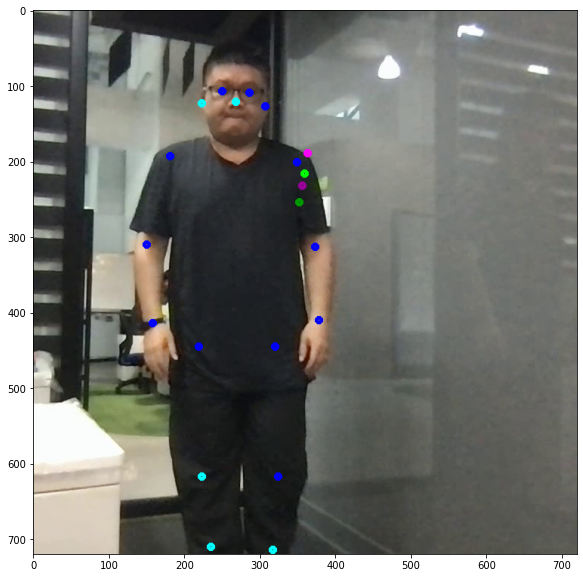

In [35]:
import matplotlib.pyplot as plt

input_method = 31

input_part   = 'body'
image_target = image_rgb.copy()

for keypoint in keypoints_with_scores[0][0]:
    y_coordinate = int( keypoint[0] * high  )
    x_coordinate = int( keypoint[1] * width )
    score = keypoint[2]

    if score > 0.8:
        cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (0,0,255), 3)
    elif score > 0.4:
        cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (0,255,255), 3)
    else:
        cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (255,0,0), 3)



_ = got_user_coordinate_from_both(
            user_base_dictionary,
            tutor_label_dictionary,
            keypoints_with_scores[0][0].numpy(),
            i_type = 'angle',
            i_part = input_part,
            i_method = input_method,
            rate_method = '1'
)

y_coordinate = int( _[0] * high  )
x_coordinate = int( _[1] * width )

cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (155,0,155), 3)


_ = got_user_coordinate_from_both(
            user_base_dictionary, 
            tutor_label_dictionary, 
            keypoints_with_scores[0][0].numpy(), 
            i_type = 'angle',
            i_part = input_part,
            i_method = input_method,
            rate_method = 'real'
)

y_coordinate = int( _[0] * high  )
x_coordinate = int( _[1] * width )

cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (255,0,255), 3)


_ = got_user_coordinate_from_both(
            user_base_dictionary,
            tutor_label_dictionary,
            keypoints_with_scores[0][0].numpy(),
            i_type = 'vector',
            i_part = input_part,
            i_method = input_method,
            rate_method = '1'
)

y_coordinate = int( _[0] * high  )
x_coordinate = int( _[1] * width )

cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (0 ,155, 0), 3)


_ = got_user_coordinate_from_both(
            user_base_dictionary,
            tutor_label_dictionary,
            keypoints_with_scores[0][0].numpy(),
            i_type = 'vector',
            i_part = input_part,
            i_method = input_method,
            rate_method = 'real'
)    

y_coordinate = int( _[0] * high  )
x_coordinate = int( _[1] * width )

cv2.circle(image_target, (x_coordinate, y_coordinate), 3, (0 ,255, 0), 3)



plt.figure(figsize=(10,10))
plt.imshow(image_target)
plt.show()





In [ ]:
# 123 angle [0.25561142 0.46225488 0.95311236]
# 123 vector [0.25561142 0.46225488 0.95311236]
# 13 angle [0.25561142 0.46225488 0.95311236]
# 13 vector [0.25561142 0.46225488 0.95311236]

fps :  60.0
(930, 930, 3)


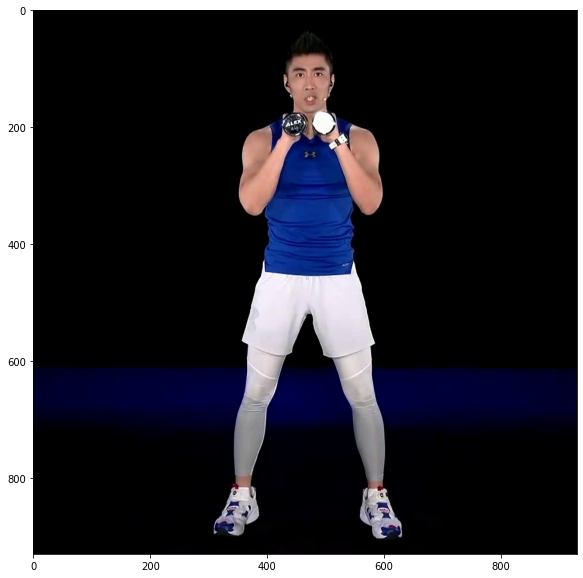

In [7]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

video_path = Path('labels/Allen-Strtength-Square.mp4')
count_stop = 10

cap = cv2.VideoCapture( str(video_path) )

fps = cap.get(cv2.CAP_PROP_FPS)
print('fps : ', fps)

count = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    count += 1
    if count == count_stop:
        print(frame.shape)
        break
    

cap.release()

image_bgr = frame


plt.figure(figsize=(10,10))
plt.imshow(image_bgr[:,:,::-1])
plt.show()



<tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.13220848, 0.48924538, 0.7835514 ],
         [0.11808832, 0.507338  , 0.9269673 ],
         [0.11586474, 0.47119266, 0.7952114 ],
         [0.13349646, 0.5322431 , 0.77458894],
         [0.13432735, 0.44855928, 0.90710753],
         [0.22873516, 0.58873   , 0.8840973 ],
         [0.22969893, 0.39119416, 0.9431269 ],
         [0.364413  , 0.5937075 , 0.8451284 ],
         [0.35422954, 0.37843633, 0.9374558 ],
         [0.2379654 , 0.52156335, 0.68903804],
         [0.23534794, 0.4421858 , 0.7823508 ],
         [0.4937326 , 0.5439259 , 0.7958367 ],
         [0.49153888, 0.44074002, 0.8200263 ],
         [0.7043596 , 0.5884723 , 0.858057  ],
         [0.712831  , 0.39008403, 0.8353869 ],
         [0.8764602 , 0.6147037 , 0.89300144],
         [0.88198245, 0.36701894, 0.91249615]]]], dtype=float32)>

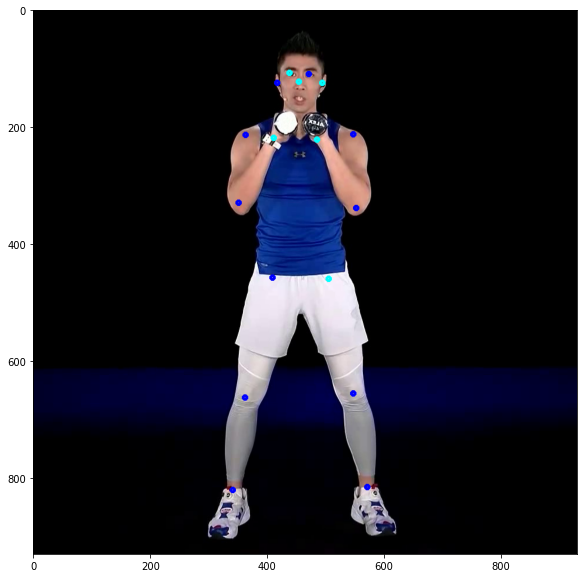

In [8]:
import tensorflow as tf

model_path = 'utils/models/movenet_t'

model_load = tf.saved_model.load(model_path)
model = model_load.signatures['serving_default']
_, target_height, target_width, _ = model.inputs[0].shape


frame = cv2.flip(frame, 1)
    
high, width, _ = frame.shape
# square
if high < width:
    x = int((width-high)/2); y = 0
    w = high; h = high; width = high
    frame = frame[y:y+h, x:x+w]
elif high > width:
    x = 0; y = int((high-width)/2)
    w = width; h = width; high = width
    frame = frame[y:y+h, x:x+w]

image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image_resize = cv2.resize(image_rgb, (target_width, target_height), interpolation=cv2.INTER_AREA)
image_r0 = tf.expand_dims(image_resize, axis=0)


input_image = tf.cast(image_r0, dtype=tf.int32)
keypoints_with_scores = model(input_image)['output_0']

tutor_keypoints_with_scores = keypoints_with_scores

display(tutor_keypoints_with_scores)

for keypoint in keypoints_with_scores[0][0]:
    y_coordinate = int( keypoint[0] * high  )
    x_coordinate = int( keypoint[1] * width )
    score = keypoint[2]

    if score > 0.8:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (0,0,255), 3)
    elif score > 0.4:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (0,255,255), 3)
    else:
        cv2.circle(image_rgb, (x_coordinate, y_coordinate), 3, (255,0,0), 3)


plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.show()




# 點位順序

* 00. nose
* 01. left eye
* 02. right eye
* 03. left ear
* 04. right ear
* 05. left shoulder
* 06. right shoulder
* 07. left elbow
* 08. right elbow
* 09. left wrist
* 10. right wrist
* 11. left hip
* 12. right hip
* 13. left knee
* 14. right knee
* 15. left ankle
* 16. right ankle


## Four Keypoints

* 5, 6, 11, 12




In [82]:
import numpy as np


_distance = 5/72

index_1 = 5
index_2 = 7

y1_coordinate = np.array(user_keypoints_with_scores[0][0][index_1])[0]
x1_coordinate = np.array(user_keypoints_with_scores[0][0][index_1])[1]
y2_coordinate = np.array(user_keypoints_with_scores[0][0][index_2])[0]
x2_coordinate = np.array(user_keypoints_with_scores[0][0][index_2])[1]

x_diff =     x2_coordinate - x1_coordinate
y_diff = - ( y2_coordinate - y1_coordinate )

print('x distance : ', x_diff, ' y distance : ', y_diff)
vector = np.complex(x_diff, y_diff)
# angle_1 = np.angle(vector, deg=True)
angle_1 = np.angle(vector)
print('Angle : ', angle_1)

_l = (x_diff ** 2 + y_diff ** 2) ** (0.5)

print('Length : ', _l)

np.cos(angle_1) * _l, np.sin(angle_1) * _l



x distance :  0.06980306  y distance :  -0.10990177
Angle :  -1.004938220043713
Length :  0.13019549269340597


(0.06980305910110474, -0.10990177094936372)

In [87]:
def next_coordinate(x_coor, y_coor, angle, _l):
    x_new = x_coor + np.cos(angle) * _l
    y_new = y_coor - np.sin(angle) * _l
    return x_new, y_new


display( next_coordinate(x1_coordinate, y1_coordinate, angle_1, _l) )
display(                (x2_coordinate, y2_coordinate)              )








(0.7265106439590454, 0.3511907756328583)

(0.72651064, 0.35119078)

In [83]:

5/72



0.06944444444444445

# 自己標註格式


In [123]:
import pickle

pickle_coach_path = 'labels/Emily-Change-Hands-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)



In [126]:

len(coach_keypoint_list)


79

In [127]:
coach_keypoint_list[0]
tutor_0 = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint_list[0])

tutor_0



{'left_arm': {'al_12': {'angle': -1.3819492792921397,
   'length': 0.11590145528316498,
   'y_diff': -0.11384087800979614,
   'x_diff': 0.021757781505584717},
  'al_23': {'angle': -1.3713710357550946,
   'length': 0.10121919959783554,
   'y_diff': -0.09921309351921082,
   'x_diff': 0.02005213499069214},
  'al_13': {'angle': -1.3770178247920253,
   'length': 0.21711763739585876,
   'y_diff': -0.21305397152900696,
   'x_diff': 0.041809916496276855}},
 'right_arm': {'al_12': {'angle': -1.6640961165227404,
   'length': 0.16170147061347961,
   'y_diff': -0.16099819540977478,
   'x_diff': -0.015064835548400879},
  'al_23': {'angle': -1.4489150579927088,
   'length': 0.12219616025686264,
   'y_diff': -0.12128967046737671,
   'x_diff': 0.014856576919555664},
  'al_13': {'angle': -1.5715340793384376,
   'length': 0.28228795528411865,
   'y_diff': -0.2822878658771515,
   'x_diff': -0.00020825862884521484}},
 'left_leg': {'al_12': {'angle': -1.261651388232998,
   'length': 0.17756879329681396,
  

In [73]:

for i in range(8):
    _ = len(coach_keypoint_list) * ( i / 7 )
    print( i, ' : ', int(_) )



0  :  0
1  :  27
2  :  54
3  :  82
4  :  109
5  :  137
6  :  164
7  :  192


In [66]:
import time

start_time = time.time()
time.sleep(1)
end_time = time.time()

end_time - start_time



1.0035030841827393

# Allen Labels

In [38]:
import pickle
import json

pickle_coach_path = 'labels/Allen-Strtength-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

# Json Data Sample
sample_json = {
  "label" : [],
  "duration" : 10,
  "focusOnHumanKeypoint": [
    {
      "part" : "left_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 9,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index":  10, "d": 0.1 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 10,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index":  10, "d": 0.1 },
      ]
    },
    {
      "part" : "left_leg",
      "type" : "angle",
      "method" : 12,
      "k_index" : 13,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":   0, "d": 0.07 },
        { "label_index":  27, "d": 0.07 },
        { "label_index":  54, "d": 0.07 },
        { "label_index":  82, "d": 0.07 },
        { "label_index": 109, "d": 0.07 },
        { "label_index": 137, "d": 0.07 },
        { "label_index": 164, "d": 0.07 },
        { "label_index": 191, "d": 0.07 },
      ]
    },
    {
      "part" : "right_leg",
      "type" : "angle",
      "method" : 12,
      "k_index" : 14,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":   0, "d": 0.07 },
        { "label_index":  27, "d": 0.07 },
        { "label_index":  54, "d": 0.07 },
        { "label_index":  82, "d": 0.07 },
        { "label_index": 109, "d": 0.07 },
        { "label_index": 137, "d": 0.07 },
        { "label_index": 164, "d": 0.07 },
        { "label_index": 191, "d": 0.07 },
      ]
    }
  ]
}


for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    sample_json["label"].append(_)


with open('utils/datas/data-allen.json', 'w') as f:
    json.dump(sample_json, f, indent=4)




In [99]:
for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    break

In [100]:
with open('mytest.json', 'w') as f:
    json.dump(_, f, indent=4) 



In [81]:
sample_json["label"][10]['keypoints']

array([[0.13444151, 0.5095732 , 0.8010272 ],
       [0.11819533, 0.5263893 , 0.8772351 ],
       [0.11758282, 0.48913333, 0.88942647],
       [0.12976605, 0.54968697, 0.84565794],
       [0.13354866, 0.46495152, 0.897473  ],
       [0.22844407, 0.6123443 , 0.80640864],
       [0.22883601, 0.40922722, 0.8236518 ],
       [0.36399788, 0.6192375 , 0.8414383 ],
       [0.35788256, 0.40319765, 0.91174245],
       [0.24589056, 0.55559283, 0.6961503 ],
       [0.23929438, 0.4739825 , 0.59825104],
       [0.49394917, 0.56034535, 0.8229511 ],
       [0.49184835, 0.45501468, 0.8391144 ],
       [0.7085769 , 0.6055569 , 0.85273397],
       [0.70887756, 0.40907782, 0.9009036 ],
       [0.87964696, 0.6289337 , 0.84276253],
       [0.8734537 , 0.38434744, 0.82205427]], dtype=float32)

# 測試 Json 檔案


In [22]:
def view_data(_data, index=0):
    pre_text = '\t' * index
    if type(_data) is dict:
        for _key in _data.keys():
            print(pre_text, 'Key: ', _key, ' Type: ', type(_data[_key]))
            view_data(_data[_key], (index+1))
    elif type(_data) is list:
        view_data(_data[0], index)

# 讀取 json
with open('utils/datas/data-allen.json', 'r') as f:
    read_data = json.load(f)

display(read_data.keys())

view_data(read_data)



dict_keys(['label', 'duration', 'focusOnHumanKeypoint'])

 Key:  label  Type:  <class 'list'>
	 Key:  left_arm  Type:  <class 'dict'>
		 Key:  al_12  Type:  <class 'dict'>
			 Key:  angle  Type:  <class 'float'>
			 Key:  length  Type:  <class 'float'>
			 Key:  y_diff  Type:  <class 'float'>
			 Key:  x_diff  Type:  <class 'float'>
		 Key:  al_23  Type:  <class 'dict'>
			 Key:  angle  Type:  <class 'float'>
			 Key:  length  Type:  <class 'float'>
			 Key:  y_diff  Type:  <class 'float'>
			 Key:  x_diff  Type:  <class 'float'>
		 Key:  al_13  Type:  <class 'dict'>
			 Key:  angle  Type:  <class 'float'>
			 Key:  length  Type:  <class 'float'>
			 Key:  y_diff  Type:  <class 'float'>
			 Key:  x_diff  Type:  <class 'float'>
	 Key:  right_arm  Type:  <class 'dict'>
		 Key:  al_12  Type:  <class 'dict'>
			 Key:  angle  Type:  <class 'float'>
			 Key:  length  Type:  <class 'float'>
			 Key:  y_diff  Type:  <class 'float'>
			 Key:  x_diff  Type:  <class 'float'>
		 Key:  al_23  Type:  <class 'dict'>
			 Key:  angle  Type:  <class 'float'>
	

# Emily Change Hands Square

In [129]:
import pickle

pickle_coach_path = 'labels/Emily-Change-Hands-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

_l = len(coach_keypoint_list)
display( _l )

( _l - 1 ) * ( 1 / 7 ), ( _l - 1 ) * ( 2 / 7 ), ( _l - 1 ) * ( 3 / 7 ), ( _l - 1 ) * ( 4 / 7 ), ( _l - 1 ) * ( 5 / 7 ), ( _l - 1 ) * ( 6 / 7 )



79

(11.142857142857142,
 22.285714285714285,
 33.42857142857142,
 44.57142857142857,
 55.714285714285715,
 66.85714285714285)

In [39]:
import pickle
import json

pickle_coach_path = 'labels/Emily-Change-Hands-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

# Json Data Sample
sample_json = {
  "label" : [],
  "duration" : 10,
  "focusOnHumanKeypoint": [
    {
      "part" : "left_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 9,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.08 },
        { "label_index": 11, "d": 0.08 },
        { "label_index": 33, "d": 0.08 },
        { "label_index": 44, "d": 0.08 },
        { "label_index": 55, "d": 0.08 },
        { "label_index": 66, "d": 0.08 },
        { "label_index": 77, "d": 0.08 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 10,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.08 },
        { "label_index": 11, "d": 0.08 },
        { "label_index": 22, "d": 0.08 },
        { "label_index": 33, "d": 0.08 },
        { "label_index": 44, "d": 0.08 },
        { "label_index": 55, "d": 0.08 },
        { "label_index": 66, "d": 0.08 },
        { "label_index": 77, "d": 0.08 },
      ]
    },
    {
      "part" : "body",
      "type" : "vector",
      "method" : 31,
      "k_index" : 5,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "body",
      "type" : "vector",
      "method" : 42,
      "k_index" : 6,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    }
  ]
}


for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    sample_json["label"].append(_)


with open('utils/datas/data-emily-change-hands.json', 'w') as f:
    json.dump(sample_json, f, indent=4)





# Emily Down Ankle Right


In [1]:
import pickle

pickle_coach_path = 'labels/Emily-Down-Ankle-Right-Square.pickle'

with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

_l = len(coach_keypoint_list)
display( _l )

( _l - 1 ) * ( 1 / 7 ), ( _l - 1 ) * ( 2 / 7 ), ( _l - 1 ) * ( 3 / 7 ), ( _l - 1 ) * ( 4 / 7 ), ( _l - 1 ) * ( 5 / 7 ), ( _l - 1 ) * ( 6 / 7 )



2023-07-10 13:30:02.517355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


116

(16.428571428571427,
 32.857142857142854,
 49.285714285714285,
 65.71428571428571,
 82.14285714285714,
 98.57142857142857)

In [19]:

for i in range(116):
    pt_1 = coach_keypoint_list[i][11]
    pt_2 = coach_keypoint_list[i][13]
    _l = changeAngleLength(pt_1, pt_2)

    pt_1 = coach_keypoint_list[i][12]
    pt_2 = coach_keypoint_list[i][14]
    _r = changeAngleLength(pt_1, pt_2)

    print(i, ' left : ', _l[0], ' right : ', _r[0])




0  left :  -1.31922328126207  right :  -1.8948648453110577
1  left :  -1.319293562896654  right :  -1.8941191567477167
2  left :  -1.3164414119903765  right :  -1.887271385277787
3  left :  -1.307697485829615  right :  -1.8960721287727484
4  left :  -1.3087309506205267  right :  -1.8922107914168382
5  left :  -1.306237351092388  right :  -1.8753680973292208
6  left :  -1.3075539444025905  right :  -1.8718185539416103
7  left :  -1.3119512810211653  right :  -1.8791121699379487
8  left :  -1.3110110475570482  right :  -1.8839095395183578
9  left :  -1.31066481102817  right :  -1.8863611293984706
10  left :  -1.3118688359088395  right :  -1.8875970453219633
11  left :  -1.3109198465167118  right :  -1.887699824356092
12  left :  -1.3156682080670028  right :  -1.8991315090727163
13  left :  -1.3067808842753572  right :  -1.9096188898727484
14  left :  -1.3207584216376793  right :  -1.900852869952369
15  left :  -1.311097343484209  right :  -1.9029271087121946
16  left :  -1.30865876530268

In [54]:
import pickle
import json

pickle_coach_path = 'labels/Emily-Down-Ankle-Right-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

# Json Data Sample
# sample_json = {
#   "label" : [],
#   "duration" : 10,
#   "focusOnHumanKeypoint": [
#     {
#       "part" : "left_arm",
#       "type" : "angle",
#       "method" : 123,
#       "k_index" : 9,
#       "threshold" : 0.4,
#       "move_type" : "hold",
#       "checkPoints" : [
#         { "label_index": 35, "d": 0.1 },
#       ]
#     },
#     {
#       "part" : "right_arm",
#       "type" : "angle",
#       "method" : 123,
#       "k_index" : 10,
#       "threshold" : 0.4,
#       "move_type" : "hold",
#       "checkPoints" : [
#         { "label_index": 35, "d": 0.1 },
#       ]
#     },
#     {
#       "part" : "left_leg",
#       "type" : "angle",
#       "method" : 12,
#       "k_index" : 13,
#       "threshold" : 0.4,
#       "move_type" : "vector",
#       "checkPoints" : [
#         { "label_index":   0, "d": 0.04 },
#         { "label_index":  16, "d": 0.04 },
#         { "label_index":  32, "d": 0.04 },
#         { "label_index":  49, "d": 0.04 },
#         { "label_index":  65, "d": 0.04 },
#         { "label_index":  82, "d": 0.04 },
#         { "label_index":  98, "d": 0.04 },
#         { "label_index": 115, "d": 0.04 },
#       ]
#     },
#     {
#       "part" : "right_leg",
#       "type" : "angle",
#       "method" : 12,
#       "k_index" : 14,
#       "threshold" : 0.4,
#       "move_type" : "hold",
#       "checkPoints" : [
#         { "label_index":  35, "d": 0.1 },
#       ]
#     }
#   ]
# }

sample_json = {
  "label" : [],
  "duration" : 10,
  "focusOnHumanKeypoint": [
    {
      "part" : "left_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 9,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 10,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "left_leg",
      "type" : "slope",
      "method" : 11,
      "k_index" : 13,
      "k_1" : 11,
      "k_2" : 13,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":   0, "d": 0.2 },
        { "label_index":  16, "d": 0.2 },
        { "label_index":  32, "d": 0.2 },
        { "label_index":  49, "d": 0.2 },
        { "label_index":  65, "d": 0.2 },
        { "label_index":  82, "d": 0.2 },
        { "label_index":  98, "d": 0.2 },
        { "label_index": 115, "d": 0.2 },
      ]
    },
    {
      "part" : "right_leg",
      "type" : "slope",
      "method" : 12,
      "k_index" : 14,
      "k_1" : 12,
      "k_2" : 14,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":   0, "d": 0.06 },
        { "label_index":  16, "d": 0.06 },
        { "label_index":  32, "d": 0.06 },
        { "label_index":  49, "d": 0.06 },
        { "label_index":  65, "d": 0.06 },
        { "label_index":  82, "d": 0.06 },
        { "label_index":  98, "d": 0.06 },
        { "label_index": 115, "d": 0.06 },
      ]
    }
  ]
}


for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    sample_json["label"].append(_)


with open('utils/datas/data-emily-down-ankle-right.json', 'w') as f:
    json.dump(sample_json, f, indent=4)



# Emily Down Ankle Left


In [139]:
import pickle

pickle_coach_path = 'labels/Emily-Down-Ankle-Left-Square.pickle'

with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

_l = len(coach_keypoint_list)
display( _l )

( _l - 1 ) * ( 1 / 7 ), ( _l - 1 ) * ( 2 / 7 ), ( _l - 1 ) * ( 3 / 7 ), ( _l - 1 ) * ( 4 / 7 ), ( _l - 1 ) * ( 5 / 7 ), ( _l - 1 ) * ( 6 / 7 )


78

(11.0, 22.0, 33.0, 44.0, 55.0, 66.0)

In [52]:
import pickle
import json

pickle_coach_path = 'labels/Emily-Down-Ankle-Left-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

# Json Data Sample
sample_json = {
  "label" : [],
  "duration" : 10,
  "focusOnHumanKeypoint": [
    {
      "part" : "left_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 9,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 123,
      "k_index" : 10,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "left_leg",
      "type" : "slope",
      "method" : 11,
      "k_index" : 13,
      "k_1" : 11,
      "k_2" : 13,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.2 },
        { "label_index": 11, "d": 0.2 },
        { "label_index": 22, "d": 0.2 },
        { "label_index": 33, "d": 0.2 },
        { "label_index": 44, "d": 0.2 },
        { "label_index": 55, "d": 0.2 },
        { "label_index": 66, "d": 0.2 },
        { "label_index": 77, "d": 0.2 },
      ]
    },
    {
      "part" : "right_leg",
      "type" : "slope",
      "method" : 12,
      "k_index" : 14,
      "k_1" : 12,
      "k_2" : 14,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.06 },
        { "label_index": 11, "d": 0.06 },
        { "label_index": 22, "d": 0.06 },
        { "label_index": 33, "d": 0.06 },
        { "label_index": 44, "d": 0.06 },
        { "label_index": 55, "d": 0.06 },
        { "label_index": 66, "d": 0.06 },
        { "label_index": 77, "d": 0.06 },
      ]
    }
  ]
}


for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    sample_json["label"].append(_)


with open('utils/datas/data-emily-down-ankle-left.json', 'w') as f:
    json.dump(sample_json, f, indent=4)


# Faye Down Ankle


In [141]:
import pickle

pickle_coach_path = 'labels/Faye-Down-Ankle-Square.pickle'

with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

_l = len(coach_keypoint_list)
display( _l )

( _l - 1 ) * ( 1 / 7 ), ( _l - 1 ) * ( 2 / 7 ), ( _l - 1 ) * ( 3 / 7 ), ( _l - 1 ) * ( 4 / 7 ), ( _l - 1 ) * ( 5 / 7 ), ( _l - 1 ) * ( 6 / 7 )


77

(10.857142857142856,
 21.71428571428571,
 32.57142857142857,
 43.42857142857142,
 54.285714285714285,
 65.14285714285714)

In [42]:
import pickle
import json

pickle_coach_path = 'labels/Faye-Down-Ankle-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

# Json Data Sample
sample_json = {
  "label" : [],
  "duration" : 10,
  "focusOnHumanKeypoint": [
    {
      "part" : "body",
      "type" : "vector",
      "method" : 42,
      "k_index" : 6,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.1 },
        { "label_index": 10, "d": 0.1 },
        { "label_index": 21, "d": 0.1 },
        { "label_index": 32, "d": 0.1 },
        { "label_index": 43, "d": 0.1 },
        { "label_index": 54, "d": 0.1 },
        { "label_index": 65, "d": 0.1 },
        { "label_index": 76, "d": 0.1 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 12,
      "k_index" : 8,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "right_leg",
      "type" : "angle",
      "method" : 23,
      "k_index" : 10,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "hold",
      "checkPoints" : [
        { "label_index":  35, "d": 0.1 },
      ]
    }
  ]
}


for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    sample_json["label"].append(_)


with open('utils/datas/data-faye-down-ankle.json', 'w') as f:
    json.dump(sample_json, f, indent=4)




# Faye Ankle Up

In [142]:
import pickle

pickle_coach_path = 'labels/Faye-Ankle-Up-Square.pickle'

with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

_l = len(coach_keypoint_list)
display( _l )

( _l - 1 ) * ( 1 / 7 ), ( _l - 1 ) * ( 2 / 7 ), ( _l - 1 ) * ( 3 / 7 ), ( _l - 1 ) * ( 4 / 7 ), ( _l - 1 ) * ( 5 / 7 ), ( _l - 1 ) * ( 6 / 7 )


70

(9.857142857142856,
 19.71428571428571,
 29.57142857142857,
 39.42857142857142,
 49.285714285714285,
 59.14285714285714)

In [43]:
import pickle
import json

pickle_coach_path = 'labels/Faye-Ankle-Up-Square.pickle'
with open(pickle_coach_path, 'rb') as f:
    coach_keypoint_list = pickle.load(f)

# Json Data Sample
sample_json = {
  "label" : [],
  "duration" : 10,
  "focusOnHumanKeypoint": [
    {
      "part" : "body",
      "type" : "vector",
      "method" : 42,
      "k_index" : 6,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index": 35, "d": 0.1 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 12,
      "k_index" : 8,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.1 },
        { "label_index":  9, "d": 0.1 },
        { "label_index": 19, "d": 0.1 },
        { "label_index": 29, "d": 0.1 },
        { "label_index": 39, "d": 0.1 },
        { "label_index": 49, "d": 0.1 },
        { "label_index": 59, "d": 0.1 },
        { "label_index": 69, "d": 0.1 },
      ]
    },
    {
      "part" : "right_arm",
      "type" : "angle",
      "method" : 23,
      "k_index" : 10,
      "k_1" : 0,
      "k_2" : 1,
      "threshold" : 0.4,
      "move_type" : "around",
      "checkPoints" : [
        { "label_index":  0, "d": 0.07 },
        { "label_index":  9, "d": 0.07 },
        { "label_index": 19, "d": 0.07 },
        { "label_index": 29, "d": 0.07 },
        { "label_index": 39, "d": 0.07 },
        { "label_index": 49, "d": 0.07 },
        { "label_index": 59, "d": 0.07 },
        { "label_index": 69, "d": 0.07 },
      ]
    }
  ]
}


for coach_keypoint in coach_keypoint_list:
    _ = changeWholeBodyAngleLengthVectorDictionary(coach_keypoint.numpy())
    _['keypoints'] = _['keypoints'].tolist()
    sample_json["label"].append(_)


with open('utils/datas/data-faye-ankle-up.json', 'w') as f:
    json.dump(sample_json, f, indent=4)






# 測試 Rate


time : 0.10430121421813965


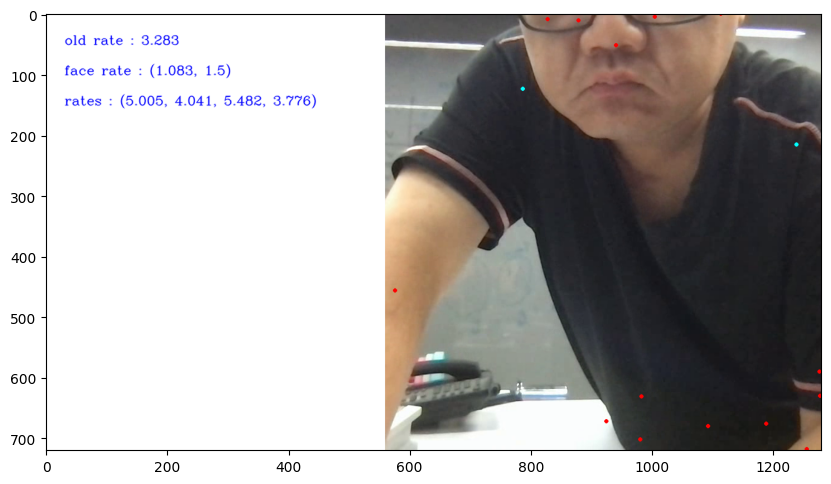

In [34]:
import cv2
import json
import time
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt


count_fix = 11
json_path = 'utils/datas/users_config.json'
video_path = 'utils/Blaze/sample_side.mp4'
model_type = 'movenet_single'  # movenet_multiple



with open(json_path, 'r') as f:
    users_config = json.load(f)

# users_config['toby']['keypoints']
user_base_dictionary = users_config['toby']



cap = cv2.VideoCapture(video_path)


# deal with model
if model_type == 'movenet_single':
    model_place = 'utils/models/movenet_t.tflite'

    interpreter = tf.lite.Interpreter(model_path=model_place)
    interpreter.allocate_tensors()
    input_details  = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

elif model_type == 'movenet_multiple':
    target_size = 256     # 32 倍數
    model_place = 'utils/models/movenet_multipose_lightning_float16.tflite'

    image_target = cv2.resize(frame, (target_size, target_size), interpolation=cv2.INTER_AREA)[:,:,::-1]
    input_tensor = tf.expand_dims(image_target, axis=0)
    interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    is_dynamic_shape_model = input_details[0]['shape_signature'][2] == -1
    if is_dynamic_shape_model:
        input_tensor_index = input_details[0]['index']
        input_shape = input_tensor.shape
        interpreter.resize_tensor_input(input_tensor_index, input_shape, strict=True)
    interpreter.allocate_tensors()


frame_dict = {}
count = 0
while cap.isOpened():
    ret, frame = cap.read()             
    if not ret:
        print("Cannot receive frame")   
        break    

    if count == count_fix:
        frame_dict['fix'] = frame
        break
    elif count == (count_fix + 1):
        frame_dict['fix+1'] = frame
    elif count == (count_fix - 1):
        frame_dict['fix-1'] = frame
    
    count += 1

cap.release()   


# image_rgb = frame_dict['fix'][:,:,::-1]
# cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

frame = cv2.flip(frame_dict['fix'], 1)
    
heigh, width, _ = frame.shape
# 裁切為正方形
if heigh < width:
    x = int((width-heigh)/2); y = 0
    w = heigh; h = heigh; width = heigh
    frame = frame[y:y+h, x:x+w]
elif heigh > width:
    x = 0; y = int((heigh-width)/2)
    w = width; h = width; heigh = width
    frame = frame[y:y+h, x:x+w]
else:
    pass


start_model = time.time()

# deal with model
# thunder 256, light 192
image = cv2.resize(frame, (input_details[0]['shape'][1], input_details[0]['shape'][1]), interpolation=cv2.INTER_AREA)
image = tf.expand_dims(image, axis=0)
interpreter.set_tensor(input_details[0]['index'], tf.cast(image, dtype=tf.uint8).numpy())
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
# keypoints_with_scores

end_model = time.time()

print(f"time : {end_model - start_model}")


# Rate 

def distance(pt1, pt2):
    return np.sqrt((pt2[1] - pt1[1])**2 + (pt1[0] - pt2[0])**2)

def human_face_distance(face):
    dist_01 = distance(face[0], face[1])
    dist_02 = distance(face[0], face[2])
    dist_03 = distance(face[0], face[3])
    dist_04 = distance(face[0], face[4])
    rate_eye = dist_01 / dist_02
    rate_ear = dist_03 / dist_04
    return round(rate_eye, 3), round(rate_ear, 3)

def catch_rate_new(face1, face2):
    face1_01 = distance(face1[0], face1[1])
    face1_02 = distance(face1[0], face1[2])
    face1_03 = distance(face1[0], face1[3])
    face1_04 = distance(face1[0], face1[4])

    face2_01 = distance(face2[0], face2[1])
    face2_02 = distance(face2[0], face2[2])
    face2_03 = distance(face2[0], face2[3])
    face2_04 = distance(face2[0], face2[4])

    rate_01 = face1_01 / face2_01
    rate_02 = face1_02 / face2_02
    rate_03 = face1_03 / face2_03
    rate_04 = face1_04 / face2_04

    return round(rate_01, 3), round(rate_02, 3), round(rate_03, 3), round(rate_04, 3)



def catch_rate(user_keypoints, real_keypoints):
    threshold = 0.4
    count = 0
    accumulation = 0
    trust_keys = [
        { 'start' : 0,
          'end'   : [5,6,11,12] },
        { 'start' : 5,
          'end'   : [6,11] },
        { 'start' : 6,
          'end'   : [12] },
        { 'start' : 11,
          'end'   : [12] },
    ]
    for trust_dictionary in trust_keys:
        for end_index in trust_dictionary['end']:
            i = trust_dictionary['start']
            j = end_index
            if real_keypoints[i][2] > threshold and real_keypoints[j][2] > threshold:
                count += 1
                real_d = np.sqrt(
                        (real_keypoints[i][0] - real_keypoints[j][0]) ** 2 + 
                        (real_keypoints[i][1] - real_keypoints[j][1]) ** 2
                    )
                user_d = np.sqrt(
                        (user_keypoints[i][0] - user_keypoints[j][0]) ** 2 + 
                        (user_keypoints[i][1] - user_keypoints[j][1]) ** 2
                    )
                rate = real_d / user_d
                accumulation += rate
    if count == 0:
        return 1
    rate = accumulation / count
    return rate


rate_old = catch_rate(users_config['toby']['keypoints'], keypoints_with_scores[0][0])
# print(f"rate : {rate_old}")
face_rates = human_face_distance(keypoints_with_scores[0][0])
# print('face rates : ', face_rates)
rates_new = catch_rate_new(keypoints_with_scores[0][0], user_base_dictionary['keypoints'])

# draw
for keypoint in keypoints_with_scores[0][0]:
    y_coordinate = int( keypoint[0] * heigh  )
    x_coordinate = int( keypoint[1] * width )
    score = keypoint[2]

    if score > 0.8:
        cv2.circle(frame, (x_coordinate, y_coordinate), 2, (255,0,0), 2)
    elif score > 0.4:
        cv2.circle(frame, (x_coordinate, y_coordinate), 2, (255,255,0), 2)
    else:
        cv2.circle(frame, (x_coordinate, y_coordinate), 2, (0,0,255), 2)


# 白畫布
white_img = np.ones((720,560,3), dtype=np.uint8) * 255


# 寫入一個

text = 'old rate : ' + str(round(rate_old, 3))
cv2.putText(white_img, text, (30, 50), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 1, cv2.LINE_AA)

text = 'face rate : ' + str(face_rates)
# cv2.putText(white_img, text, (50, 50), font, font_scale, color, thickness)
cv2.putText(white_img, text, (30, 100), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 1, cv2.LINE_AA)

text = 'rates : ' + str(rates_new)
cv2.putText(white_img, text, (30, 150), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 1, cv2.LINE_AA)




image_out = cv2.hconcat([white_img, frame])

plt.figure(figsize=(10, 10))
plt.imshow(image_out[:,:,::-1])
plt.show()




# Video

In [53]:
import cv2
import json
import time
import numpy as np
import tensorflow as tf


json_path = 'utils/datas/users_config.json'
video_path = 'utils/Blaze/sample_side.mp4'
model_type = 'movenet_single'  # movenet_multiple
# model_type = 'movenet_multiple'


with open(json_path, 'r') as f:
    users_config = json.load(f)

# users_config['toby']['keypoints']
user_base_dictionary = users_config['toby']


# 錄製參數設定
fps = 20
frame_size = (1280, 720)
# 建立 VideoWriter 物件
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_rate_test.mp4', fourcc, fps, frame_size)


# Rate 
def distance(pt1, pt2):
    return np.sqrt((pt2[1] - pt1[1])**2 + (pt1[0] - pt2[0])**2)

# def human_face_distance(face):
#     dist_01 = distance(face[0], face[1])
#     dist_02 = distance(face[0], face[2])
#     dist_03 = distance(face[0], face[3])
#     dist_04 = distance(face[0], face[4])
#     rate_eye = dist_01 / dist_02
#     rate_ear = dist_03 / dist_04
#     return round(rate_eye, 3), round(rate_ear, 3)

def catch_rate_new(face1, face2):
    face1 = list(map(lambda i: distance(face1[0], face1[i]), [1,2,3,4]))
    face2 = list(map(lambda i: distance(face2[0], face2[i]), [1,2,3,4]))
    rate = [face1[i] / face2[i] for i in range(4)]

    rate_eye = face1[0] / face1[1]
    rate_ear = face1[2] / face1[3]
    
    if 0.8 < rate_eye < 1.2 and 0.8 < rate_ear < 1.2:
        return round(sum(rate)/4, 3)
    else:
        return -1


def catch_rate(user_keypoints, real_keypoints):
    threshold = 0.4
    count = 0
    accumulation = 0
    trust_keys = [
        { 'start' : 0,
          'end'   : [5,6,11,12] },
        { 'start' : 5,
          'end'   : [6,11] },
        { 'start' : 6,
          'end'   : [12] },
        { 'start' : 11,
          'end'   : [12] },
    ]
    for trust_dictionary in trust_keys:
        for end_index in trust_dictionary['end']:
            i = trust_dictionary['start']
            j = end_index
            if real_keypoints[i][2] > threshold and real_keypoints[j][2] > threshold:
                count += 1
                real_d = np.sqrt(
                        (real_keypoints[i][0] - real_keypoints[j][0]) ** 2 + 
                        (real_keypoints[i][1] - real_keypoints[j][1]) ** 2
                    )
                user_d = np.sqrt(
                        (user_keypoints[i][0] - user_keypoints[j][0]) ** 2 + 
                        (user_keypoints[i][1] - user_keypoints[j][1]) ** 2
                    )
                rate = real_d / user_d
                accumulation += rate
    if count == 0:
        return 1
    rate = accumulation / count
    return rate



cap = cv2.VideoCapture(video_path) 

# deal with model
if model_type == 'movenet_single':
    model_place = 'utils/models/movenet_t.tflite'

    interpreter = tf.lite.Interpreter(model_path=model_place)
    interpreter.allocate_tensors()
    input_details  = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

elif model_type == 'movenet_multiple':
    # target_size = 256     # 32 倍數
    model_place = 'utils/models/movenet_multipose_lightning_float16.tflite'

    # image_target = cv2.resize(frame, (target_size, target_size), interpolation=cv2.INTER_AREA)[:,:,::-1]
    # input_tensor = tf.expand_dims(image_target, axis=0)
    interpreter = tf.lite.Interpreter(model_path=model_place)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    is_dynamic_shape_model = input_details[0]['shape_signature'][2] == -1
    if is_dynamic_shape_model:
        input_tensor_index = input_details[0]['index']
        input_shape = (1, 256, 256, 3)
        # print(f"Input shape : {input_shape}")
        interpreter.resize_tensor_input(input_tensor_index, input_shape, strict=True)
    interpreter.allocate_tensors()


# frame_dict = {}
while cap.isOpened():
    ret, frame = cap.read()             
    if not ret:
        print("Cannot receive frame")   
        break    

    frame = cv2.flip(frame, 1)
    
    heigh, width, _ = frame.shape
    # 裁切為正方形
    if heigh < width:
        x = int((width-heigh)/2); y = 0
        w = heigh; h = heigh; width = heigh
        frame = frame[y:y+h, x:x+w]
    elif heigh > width:
        x = 0; y = int((heigh-width)/2)
        w = width; h = width; heigh = width
        frame = frame[y:y+h, x:x+w]
    else:
        pass

    # deal with model
    if model_type == 'movenet_single':
        # thunder 256, light 192
        image = cv2.resize(frame, (input_details[0]['shape'][1], input_details[0]['shape'][1]), interpolation=cv2.INTER_AREA)[:,:,::-1]
        image = tf.expand_dims(image, axis=0)
        interpreter.set_tensor(input_details[0]['index'], tf.cast(image, dtype=tf.uint8).numpy())
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    elif model_type == 'movenet_multiple':
        image_target = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_AREA)[:,:,::-1]
        input_tensor = tf.expand_dims(image_target, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_tensor.numpy())
        interpreter.invoke()
        multi_keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        print(multi_keypoints_with_scores)

    


    # draw
    rate_color = (255, 0, 0)
    for keypoint in keypoints_with_scores[0][0][:5]:
        y_coordinate = int( keypoint[0] * heigh  )
        x_coordinate = int( keypoint[1] * width )
        score = keypoint[2]

        if score > 0.5:
            cv2.circle(frame, (x_coordinate, y_coordinate), 2, (255,0,0), 2)
        elif score > 0.3:
            cv2.circle(frame, (x_coordinate, y_coordinate), 2, (255,255,0), 2)
            rate_color = (0, 0, 255)
        else:
            cv2.circle(frame, (x_coordinate, y_coordinate), 2, (0,0,255), 2)
            rate_color = (0, 0, 255)


    rate_old = catch_rate(users_config['toby']['keypoints'], keypoints_with_scores[0][0])
    # face_rates = human_face_distance(keypoints_with_scores[0][0])
    rates_new = catch_rate_new(keypoints_with_scores[0][0], user_base_dictionary['keypoints'])

    # 白畫布
    white_img = np.ones((720,560,3), dtype=np.uint8) * 255


    # 寫入一個
    text = 'old rate : ' + str(round(rate_old, 3))
    cv2.putText(white_img, text, (30, 50), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 1, cv2.LINE_AA)

    text = 'face rate : ' + str(face_rates)
    # cv2.putText(white_img, text, (50, 50), font, font_scale, color, thickness)
    cv2.putText(white_img, text, (30, 100), cv2.FONT_HERSHEY_COMPLEX, 0.7, rate_color, 1, cv2.LINE_AA)

    text = 'rates : ' + str(rates_new)
    cv2.putText(white_img, text, (30, 150), cv2.FONT_HERSHEY_COMPLEX, 0.7, rate_color, 1, cv2.LINE_AA)

    image_out = cv2.hconcat([white_img, frame])
    out.write(image_out)
    
cap.release()
out.release()

print('Done')


Cannot receive frame
Done


In [41]:
face1 = users_config['toby']['keypoints']

print(list(map(lambda i: distance(face1[0], face1[i]), [1,2,3,4])))

distance(face1[0], face1[1]), distance(face1[0], face1[2]), distance(face1[0], face1[3]), distance(face1[0], face1[4])


[0.022110928466522153, 0.025280376576059426, 0.04596518794897719, 0.04447627936284352]


(0.022110928466522153,
 0.025280376576059426,
 0.04596518794897719,
 0.04447627936284352)

In [42]:
sum([1,2,3,4])

10

In [6]:
users_config['toby']['keypoints']

[[0.16056102514266968, 0.5557356476783752, 0.8782555460929871],
 [0.1470610499382019, 0.5732468962669373, 0.8611133098602295],
 [0.1485932171344757, 0.5334675312042236, 0.8056036233901978],
 [0.1632714569568634, 0.6016208529472351, 0.8971351385116577],
 [0.1684015989303589, 0.5119559168815613, 0.8449698686599731],
 [0.24128900468349457, 0.6567075848579407, 0.8433470129966736],
 [0.2556114196777344, 0.4622548818588257, 0.9531123638153076],
 [0.3511907756328583, 0.7265106439590454, 0.807969331741333],
 [0.3827724754810333, 0.4163077175617218, 0.9272079467773438],
 [0.45460939407348633, 0.7853299975395203, 0.9151697158813477],
 [0.48495182394981384, 0.36648452281951904, 0.9446889162063599],
 [0.5380591750144958, 0.6141910552978516, 0.9140036106109619],
 [0.5364976525306702, 0.49908438324928284, 0.8693239688873291],
 [0.7131262421607971, 0.6242789626121521, 0.8844194412231445],
 [0.7053417563438416, 0.4900731146335602, 0.9180812239646912],
 [0.8598841428756714, 0.635932207107544, 0.9231284

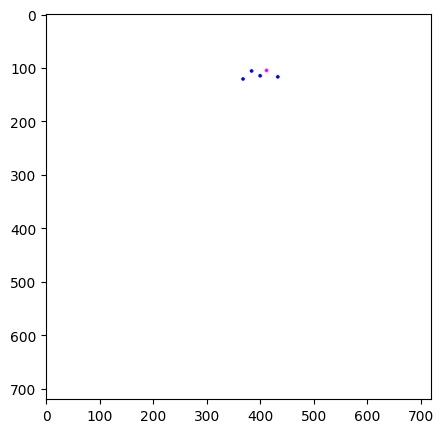

In [17]:
# 白畫布
white_img = np.ones((720, 720, 3), dtype=np.uint8) * 255
heigh, width, _ = white_img.shape


for i, keypoint in enumerate(users_config['toby']['keypoints']):
    y_coordinate = int( keypoint[0] * heigh )
    x_coordinate = int( keypoint[1] * width )
    score = keypoint[2]

    if i == 1:
        cv2.circle(white_img, (x_coordinate, y_coordinate), 2, (255,0,255), 2)
    elif i < 5:
        cv2.circle(white_img, (x_coordinate, y_coordinate), 2, (255,0,0), 2)
    else:
        break


plt.figure(figsize=(5, 5))
plt.imshow(white_img[:,:,::-1])
plt.show()





In [23]:
import numpy as np
pt1 = users_config['toby']['keypoints'][0]
pt2 = users_config['toby']['keypoints'][1]

def distance(pt1, pt2):
    return np.sqrt((pt2[1] - pt1[1])**2 + (pt1[0] - pt2[0])**2)

def human_face_distance(face):
    dist_01 = distance(face[0], face[1])
    dist_02 = distance(face[0], face[2])
    dist_03 = distance(face[0], face[3])
    dist_04 = distance(face[0], face[4])
    rate_eye = dist_01 / dist_02
    rate_ear = dist_03 / dist_04
    return rate_eye, rate_ear


str(human_face_distance(users_config['toby']['keypoints']))




'(0.8746281290548992, 1.0334764644764225)'

In [16]:
pt2[0] - pt1[0]

-0.013499975204467773

In [57]:
my_dict = {'k_index': 10}

'moveType' in my_dict.keys()


False